<a href="https://colab.research.google.com/github/hanaessamm/CodeAlpha_Object_Detection/blob/main/Hough__Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python numpy matplotlib

In [ ]:
from google.colab import files
files.upload()

Saving road.jpg to road.jpg


{'road.jpg': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03W\x00\x00\x01\xd7\x08\x06\x00\x00\x00P\xed\xa0\x01\x00\x00\x18~iCCPICC Profile\x00\x00X\x85\x95y\x07TT\xcb\xb2v\xef\xc93\xe4\x19r\xce\x19$\xe7\x9cs\xce \x02C\x1a\x920D\x01E\x10Q\x82"\x88\x80\xa0\xa8\x88D\x15\x15\x05T\x04A\x0c(J\xf0\x80\x88\x88 \x12T\x14PA%\xc8\xdb\x04=\xe7\x9e\xfb\xaf\xff\xad\xd7k\xf5\xeeo\xaa\xab\xab\xba\xab\xbb\xbav\xcd\x06\x80k\xc4722\x0c\xc1\x08@xD\x0c\xd5\xc1\xd4\x80\xdf\xcd\xdd\x83\x1f\xfb\x1e \x00\x01`\x808\xc0\xf9\x92\xa3#\xf5\xed\xec\xac\x00\\~\xb7\xffY\x96\x06\x01\xb4\xd1>\x97\xd9\x90\xf5\xdf\xfd\xff\xdfB\xf4\x0f\x88&\x03\x00y\xc1\xd8\xcf?\x9a\x1c\x0e\xe3\xbb\x00\xa0N\x91#\xa91\x00`6\xe8B\xf11\x91\x1bx?\x8c\x99\xa9\xf0\x04a\\\xb0\x81\x83\xb6p\xf5\x06\xf6\xdb\xc2-\x9b<N\x0e\x860\xee\x05\x00G\xeb\xebK\r\x02\x80~\x04\xa6\xf3\xc7\x91\x83`9\xf4\xabp\x1f1\xc2\x9f\x12\x01\x00\x0b\xbcr\x8c\x0e9\xd8\xd7\x1f\x00.;\x98G:<|\xf7\x06N\x86\xb18\xcc\x1f\t\xe3\n\x18\xab\xf9\xfdCf\xd0\x7f\xc8\xf7\xfb#\xdf\xd77\xe8\x

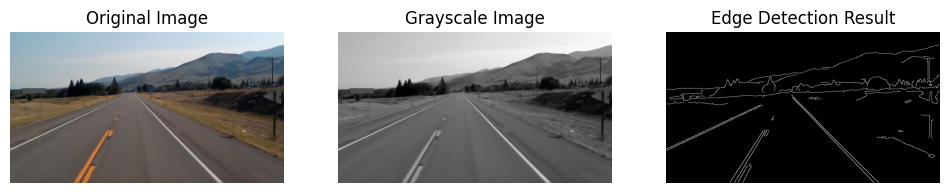

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, 5)
    return image, gray, blurred



def edge_detection(blurred):
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(blurred, (5, 5), 0)

    # Tune Canny Edge Detection thresholds
    lower_threshold = 30  # (lowering it threshold to detect weak edges.)
    upper_threshold = 100  # upper threshold (for strong edges)

    edges = cv2.Canny(blurred, lower_threshold, upper_threshold)
    return edges



image_path = 'road.jpg'
original_image, gray_image, blurred_image = preprocess_image(image_path)
edges = edge_detection(blurred_image)


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gray_image, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap="gray")
plt.title("Edge Detection Result")
plt.axis("off")

plt.show()


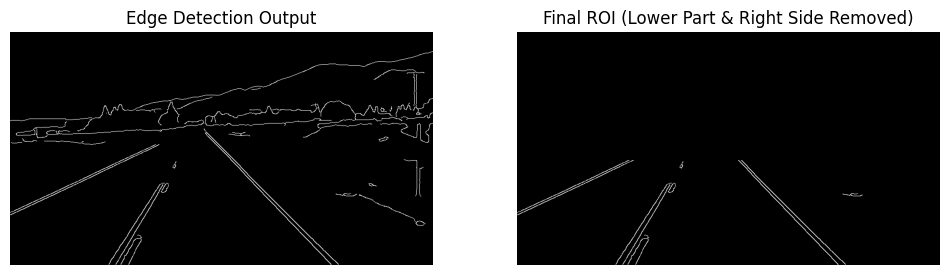

In [ ]:

def region_of_interest(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)

    # Define a polygon that keeps only the lower portion but removes the rightmost part
    polygon = np.array([[
        (0, height),       # Bottom-left corner (keep left lanes)
        (int(0.95 * width), height),   # Bottom-right (trim right part slightly)
        (int(0.75 * width), int(0.55 * height)),  # Adjusted right middle (removes right noise)
        (0, int(0.55 * height))       # Left middle (keep left lanes)
    ]], np.int32)

    # Create mask and apply it
    cv2.fillPoly(mask, polygon, 255)
    masked_edges = cv2.bitwise_and(edges, mask) #. keeps only the pixels inside the ROI.

    return masked_edges

# applying ROI to edges.
roi_edges = region_of_interest(edges)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(edges, cmap="gray")
plt.title("Edge Detection Output")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(roi_edges, cmap="gray")
plt.title("Final ROI (Lower Part & Right Side Removed)")
plt.axis("off")

plt.show()


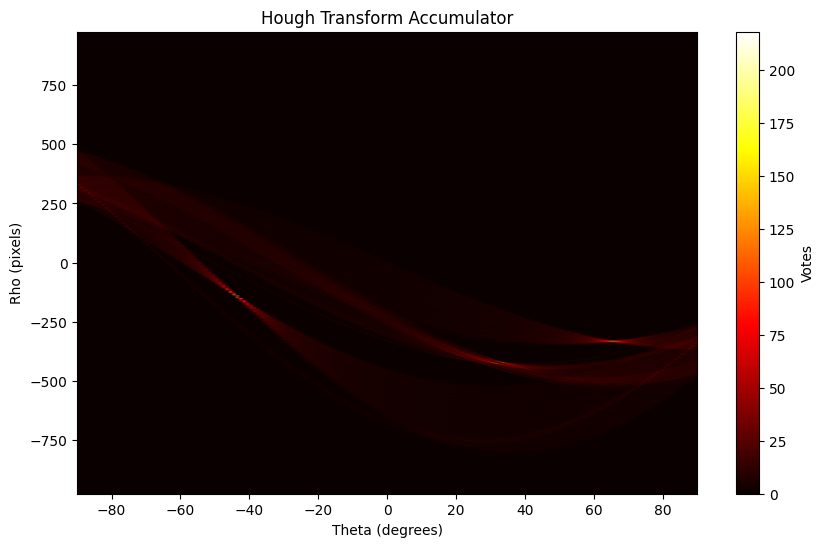

In [ ]:

def hough_transform(edge_img):
    """
    Computes the Hough Transform accumulator from edge-detected image.

    Args:
    - edge_img: Binary image after edge detection and ROI application.

    Returns:
    - accumulator: 2D Hough accumulator matrix (ρ, θ)
    - rhos: Range of possible ρ values
    - thetas: Range of θ values in radians
    """
    # image dimensions
    height, width = edge_img.shape

    # Define theta values (angle in radians)
    theta_res = 1  # 1-degree resolution
    thetas = np.deg2rad(np.arange(-90, 90, theta_res))  # Range from -90° to 89°

    # Compute max possible rho (diagonal length of image)
    diag_len = int(np.sqrt(height**2 + width**2))
    rhos = np.arange(-diag_len, diag_len, 1)  # 1-pixel resolution

    # Initialize Hough accumulator
    accumulator = np.zeros((len(rhos), len(thetas)))

    # Get edge coordinates
    edge_y, edge_x = np.nonzero(edge_img)

    # Compute Hough Transform
    for i in range(len(edge_x)):
        x = edge_x[i]
        y = edge_y[i]

        for t_idx, theta in enumerate(thetas):
            rho = int(x * np.cos(theta) + y * np.sin(theta))  # compute rho
            rho_idx = np.where(rhos == rho)[0]  # find closest rho index

            if len(rho_idx) > 0:
                accumulator[rho_idx[0], t_idx] += 1

    return accumulator, rhos, thetas

# Apply Hough Transform
accumulator, rhos, thetas = hough_transform(roi_edges)


plt.figure(figsize=(10, 6))
plt.imshow(accumulator, cmap="hot", aspect="auto", extent=[-90, 90, rhos[0], rhos[-1]])
plt.colorbar(label="Votes")
plt.title("Hough Transform Accumulator")
plt.xlabel("Theta (degrees)")
plt.ylabel("Rho (pixels)")
plt.show()


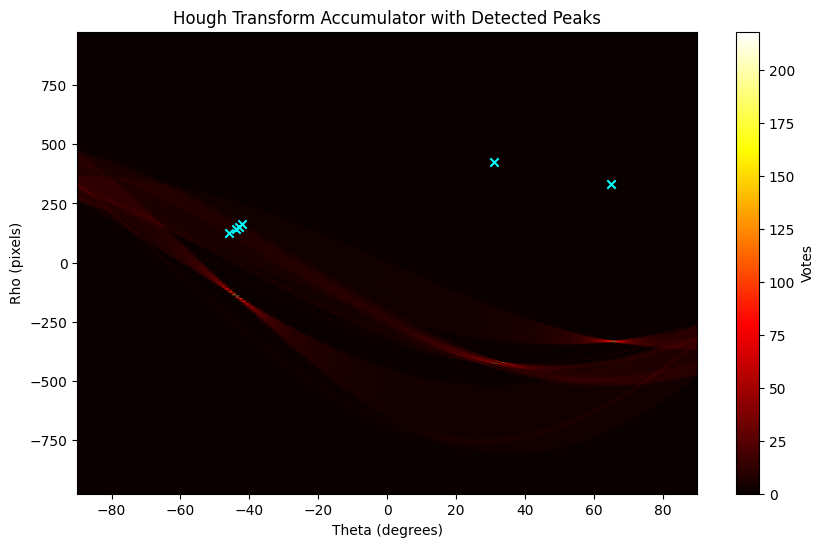

In [ ]:
def find_hough_peaks(accumulator, rhos, thetas, threshold=0.5, neighborhood_size=10):
    """
    Finds peaks in the Hough Transform accumulator using Non-Maximum Suppression.

    Args:
    - accumulator: Hough space (ρ, θ) array.
    - rhos: Array of possible ρ values.
    - thetas: Array of possible θ values.
    - threshold: Fraction of max value to consider as a peak.
    - neighborhood_size: Window size for local suppression.

    Returns:
    - List of (rho, theta) pairs for detected lines.
    """
    peaks = []
    max_val = np.max(accumulator)
    threshold_val = threshold * max_val  # threshold for peak detection.

    # Iterate over accumulator array
    for r in range(accumulator.shape[0]):
        for t in range(accumulator.shape[1]):
            if accumulator[r, t] > threshold_val:
                local_max = True  # Assume it's a peak

                # Check within the neighborhood
                for dr in range(-neighborhood_size // 2, neighborhood_size // 2 + 1):
                    for dt in range(-neighborhood_size // 2, neighborhood_size // 2 + 1):
                        nr, nt = r + dr, t + dt
                        if 0 <= nr < accumulator.shape[0] and 0 <= nt < accumulator.shape[1]:
                            if accumulator[nr, nt] > accumulator[r, t]:
                                local_max = False  # not a peak.
                                break

                if local_max:
                    peaks.append((rhos[r], thetas[t]))  # Store peak coordinates.

    return peaks

# Detect peaks in the accumulator
peaks = find_hough_peaks(accumulator, rhos, thetas, threshold=0.4, neighborhood_size=10)

plt.figure(figsize=(10, 6))
plt.imshow(accumulator, cmap="hot", aspect="auto", extent=[-90, 90, rhos[0], rhos[-1]])
plt.colorbar(label="Votes")
plt.title("Hough Transform Accumulator with Detected Peaks")
plt.xlabel("Theta (degrees)")
plt.ylabel("Rho (pixels)")


for rho, theta in peaks:
    plt.scatter(np.rad2deg(theta), rho, color='cyan', marker='x')

plt.show()


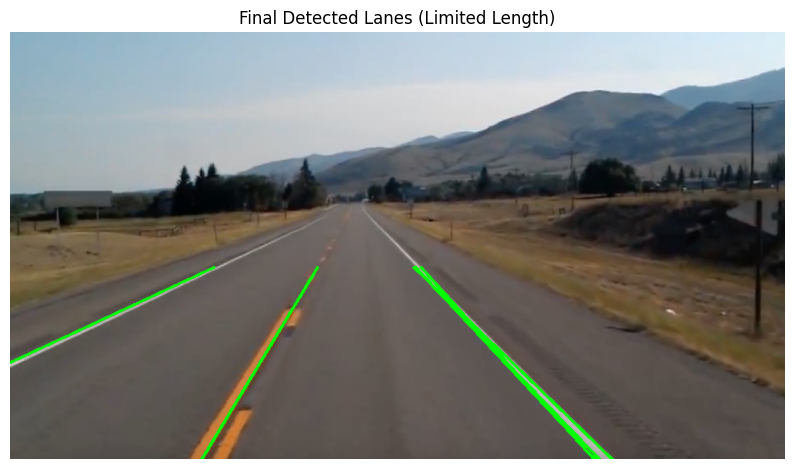

In [ ]:
def draw_limited_detected_lines(image, peaks, min_y, max_y):
    """
    Draws detected Hough lines, but limits their length to the region of interest.

    Args:
    - image: Original input image.
    - peaks: List of (rho, theta) values from Hough Transform.
    - min_y: The minimum y-value to draw lines (top of the ROI).
    - max_y: The maximum y-value to draw lines (bottom of the ROI).

    Returns:
    - Image with detected lines drawn within the specified y-range.
    """
    line_image = np.copy(image)

    for rho, theta in peaks:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho  # x = r * cos(theta)
        y0 = b * rho  # y = r * sin(theta)

        # Avoid dividing by zero when calculating x
        if np.sin(theta) == 0:
            continue

        # Compute x for min_y and max_y using line equation
        x_min = int((rho - min_y * b) / a)
        x_max = int((rho - max_y * b) / a)

        # draw only within the limited y-range
        cv2.line(line_image, (x_min, min_y), (x_max, max_y), (0, 255, 0), 2)

    return line_image

# Define the y-range based on the ROI
min_y = int(0.55 * original_image.shape[0])  # Top of ROI
max_y = original_image.shape[0]  # Bottom of the image

final_image = draw_limited_detected_lines(original_image, peaks, min_y, max_y)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.title("Final Detected Lanes (Limited Length)")
plt.axis("off")
plt.show()
